# **Sentiment Analysis on Reddit**

This program takes a subreddit, a file containing topics, and a few parameters to generate a list of topics found in posts on the subreddit and gives numerical values about the sentiment of the given topic.

To test I created a list of video games as a topic list and searched for any mention of these games on the pcgaming subreddit.

In [26]:
# Subreddit to perform sentiment analysis on:
subreddit = 'pcgaming'
# Name of file that contains the topics to search the subreddit for.
topic_file = 'topic_list.csv'
# Number of posts to check for topics in.
num_posts = 75
# Maximum number of comments to analyze from each post.
max_comments = 50

## **0. Imports**

In [27]:
import praw
import pandas as pd
import numpy as np
import nltk
from fuzzywuzzy import process, fuzz
import statistics
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

import bot1

## **1. Finding Topics**

First the posts are searched through to find posts that are about topics in the topic list.

In [28]:
def get_topic_exact(title_text, topic_df):
    """Searches through post title to return any topic in the topic dataframe.

    Args:
        title_text (str): title of the post
        topic_df (DataFrame): dataframe containing topics to search for

    Returns:
        str: topic found in the title
    """
    topic = ''
    for t in topic_df['Topic']:
        t = str(t)
        t_split = t.split()
        topic_len = len(t_split)
        post_list = title_text.split()
        ngram = nltk.ngrams(post_list, topic_len)
        for grams in ngram:
            if list(grams) == t_split:
                return ' '.join(t_split)
    return topic

reddit = praw.Reddit(client_id=bot1.app_id, client_secret=bot1.app_secret, user_agent=bot1.app_ua)
sub = reddit.subreddit(subreddit)
topic_df = pd.read_csv(topic_file)
posts = pd.DataFrame(columns=['PostID', 'Title', 'Topic'])

for post in sub.hot(limit=num_posts):
    url = 'reddit.com/r/' + subreddit + '/comments/' + post.id
    title = post.title
    topic = get_topic_exact(title, topic_df)
    if topic != '':
        posts.loc[len(posts.index)] = [post.id, title, topic]

posts

,PostID,Title,Topic
0,x8x1ip,"A Plague Tale: Requiem preview — A dark, grisl...",A Plague Tale: Requiem
1,x8x5q7,Age of Empires IV - Patch 23349,Age of Empires
2,x9497k,Steelrising has released on Steam | GOG | EGS,Steelrising
3,x90e45,Steelrising | Launch Trailer,Steelrising
4,x94c40,Evil West - Extended Gameplay Trailer #2,Evil West
5,x96dlr,Capcom 2022 TGS Presentation: Approximately 50...,Resident Evil
6,x8card,Humble Bundle: 2K Megahits Bundle - Borderland...,Borderlands
7,x88usb,"FlatOut Inspired Game ""TRAIL OUT"" has released...",FlatOut
8,x894i5,"Metal Gear Solid inspired Stealth Game ""Undete...",Metal Gear Solid
9,x8bs1i,Anno 2070 - Update 3.0 is available now,Anno 2070


## **2. Sentiment Analysis on Comments**

Each posts' comments are analyzed for their sentiment and an average sentiment is determined for each post.

In [29]:
def get_comments(ID):
    """Retrieves all comments for a reddit post.

    Args:
        ID (str): id of the post

    Returns:
        DataFrame: dataframe containing each comment on the post
    """
    post = reddit.submission(id=ID)
    all_comments = []
    post.comments.replace_more(limit=None)
    for index, comments in enumerate(post.comments.list()):
        if index >= max_comments:
            break
        all_comments.append(comments.body)
    return pd.DataFrame(all_comments, columns=['Comment'])

def score_comments(ID):
    """Determines average seniment of all comments on given post.

    Args:
        ID (str): id of the post

    Returns:
        List: list of average sentiment values for all comments
    """
    comments_df = get_comments(ID)
    num_comments = len(comments_df.index)
    if num_comments == 0:
        out_values = []
        return out_values
    sia = SentimentIntensityAnalyzer()
    results = []
    for index, row in comments_df.iterrows():
        pol_score = sia.polarity_scores(row['Comment'])
        comments_df.loc[index,'pos'] = pol_score['pos']
        comments_df.loc[index,'neu'] = pol_score['neu']
        comments_df.loc[index,'neg'] = pol_score['neg']
        comments_df.loc[index,'compound'] = pol_score['compound']
    out_values = []
    out_values.append(comments_df['pos'].mean())
    out_values.append(comments_df['neu'].mean())
    out_values.append(comments_df['neg'].mean())
    out_values.append(comments_df['compound'].mean())
    out_values.append(len(comments_df.index))
    return out_values

for index,post in enumerate(sub.hot(limit=num_posts)):
    if posts['PostID'].str.contains(post.id).any():
        out_values = score_comments(post.id)
        if out_values == []:#if there are no comments
            posts = posts.drop(posts[posts['PostID'] == post.id].index)
        else:
            index = posts.index[posts['PostID'] == post.id].tolist()
            posts.loc[index,'Avg_Pos'] = out_values[0]
            posts.loc[index,'Avg_Neu'] = out_values[1]
            posts.loc[index,'Avg_Neg'] = out_values[2]
            posts.loc[index,'Avg_Compound'] = out_values[3]
            posts.loc[index,'Num_Comments'] = out_values[4]

posts['Num_Comments'] = posts['Num_Comments'].astype('int64')
posts = posts.sort_values(by=['Avg_Compound'], ascending=False)
posts

,PostID,Title,Topic,Avg_Pos,Avg_Neu,Avg_Neg,Avg_Compound,Num_Comments
14,x894nr,Gungrave G.O.R.E. Launching Day One with Xbox ...,Gungrave G.O.R.E.,0.337000,0.621000,0.042000,0.681050,2
4,x94c40,Evil West - Extended Gameplay Trailer #2,Evil West,0.125333,0.824667,0.050000,0.373800,3
8,x894i5,"Metal Gear Solid inspired Stealth Game ""Undete...",Metal Gear Solid,0.184211,0.778711,0.037079,0.352055,38
3,x90e45,Steelrising | Launch Trailer,Steelrising,0.210500,0.758875,0.030625,0.347525,8
6,x8card,Humble Bundle: 2K Megahits Bundle - Borderland...,Borderlands,0.178160,0.748900,0.072900,0.271154,50
7,x88usb,"FlatOut Inspired Game ""TRAIL OUT"" has released...",FlatOut,0.128080,0.780940,0.090940,0.239118,50
12,x7edjl,Cyberpunk 2077 REDmod is now available on Steam,Cyberpunk 2077,0.146460,0.813200,0.040360,0.223342,50
9,x8bs1i,Anno 2070 - Update 3.0 is available now,Anno 2070,0.115600,0.859333,0.025067,0.221867,15
13,x7p8g4,"Cyberpunk 2077 Phantom Liberty Is the ""Only Pl...",Cyberpunk 2077,0.153180,0.777480,0.069380,0.200864,50
0,x8x1ip,"A Plague Tale: Requiem preview — A dark, grisl...",A Plague Tale: Requiem,0.146340,0.771420,0.082200,0.198230,50


## **3. Output Topic-Sentiment Values**

Each topic has its posts combined to find the average sentiment values of each topic.

To find the sentiment of each comment, an unsupervised sentiment algorithm named VADER(Valence Aware Dictionary and sEntiment Reasoner) is used. VADER takes in unfiltered text and outputs the following values for the text:

Sentiment values:<br>
-**Pos**: The percent of positive sentiment of the text.<br>
-**Neu**: The percent of neutral sentiment of the text.<br>
-**Neg**: The percent of negative sentiment of the text.<br>
-**Compount**: A value that represents the overall sentiment of the text.<br>
&nbsp;&nbsp;-**positive sentiment**: compound score >= 0.05 <br>
&nbsp;&nbsp;-**neutral sentiment**: -0.05 < compound score < 0.05 <br>
&nbsp;&nbsp;-**negative sentiment**: compound score <= -0.05<br>

In [30]:
topic_sentiments = pd.DataFrame(columns=['Topic', 'Avg_Pos', 'Avg_Neu', 'Avg_Neg', 'Avg_Compound', 'Num_Comments'])
for index, row in posts.iterrows():
    if topic_sentiments['Topic'].str.contains(row['Topic']).any():
        new_index = topic_sentiments.index[topic_sentiments['Topic'] == row['Topic']]
        topic_sentiments.loc[new_index,'Avg_Pos'] = (row['Avg_Pos'] + topic_sentiments.iloc[new_index]['Avg_Pos']) / 2
        topic_sentiments.loc[new_index,'Avg_Neu'] = (row['Avg_Neu'] + topic_sentiments.iloc[new_index]['Avg_Neu']) / 2
        topic_sentiments.loc[new_index,'Avg_Neg'] = (row['Avg_Neg'] + topic_sentiments.iloc[new_index]['Avg_Neg']) / 2
        topic_sentiments.loc[new_index,'Avg_Compound'] = (row['Avg_Compound'] + topic_sentiments.iloc[new_index]['Avg_Compound']) / 2
        topic_sentiments.loc[new_index,'Num_Comments'] = row['Num_Comments'] + topic_sentiments.iloc[new_index]['Num_Comments']
    else:
        topic_sentiments.loc[len(topic_sentiments.index)] = [row['Topic'], row['Avg_Pos'], row['Avg_Neu'], row['Avg_Neg'], row['Avg_Compound'], row['Num_Comments']] 

topic_sentiments

,Topic,Avg_Pos,Avg_Neu,Avg_Neg,Avg_Compound,Num_Comments
0,Gungrave G.O.R.E.,0.337000,0.621000,0.042000,0.681050,2
1,Evil West,0.125333,0.824667,0.050000,0.373800,3
2,Metal Gear Solid,0.184211,0.778711,0.037079,0.352055,38
3,Steelrising,0.162523,0.789301,0.048176,0.233072,19
4,Borderlands,0.178160,0.748900,0.072900,0.271154,50
5,FlatOut,0.128080,0.780940,0.090940,0.239118,50
6,Cyberpunk 2077,0.138300,0.789200,0.072495,0.133447,150
7,Anno 2070,0.115600,0.859333,0.025067,0.221867,15
8,A Plague Tale: Requiem,0.146340,0.771420,0.082200,0.198230,50
9,Age of Empires,0.125280,0.819560,0.055120,0.191556,25


## **4. Distribution of Sentiment Scores**

The distribution of compound sentiment value is given.

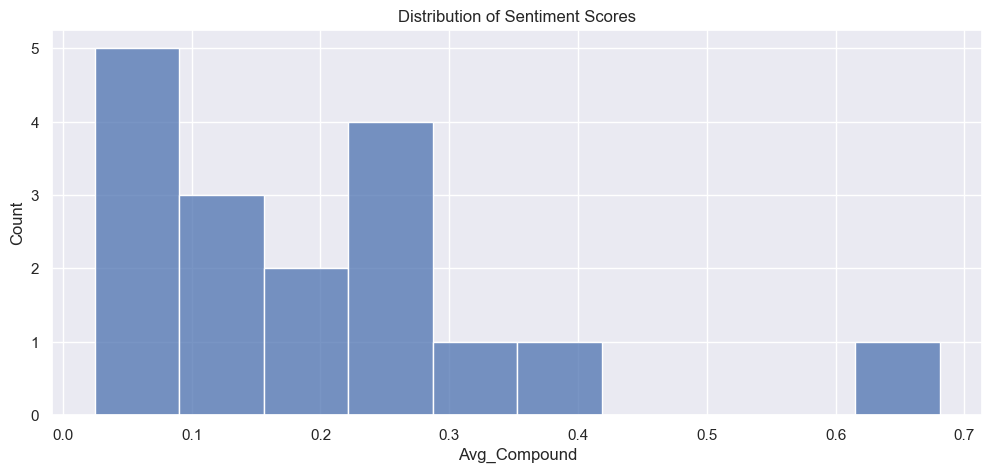

In [31]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12,5))
plt.title('Distribution of Sentiment Scores')
sns.histplot(x='Avg_Compound', data=topic_sentiments, bins=10)
plt.show()